# Divvy Bike Share Project Remake
This is my Divvy Bike Project Remake. I completed this project a year ago using R for my Google Data Analytics Certificate. I've learned a lot since then and wanted to see if I could improve upon my prior work as well as demonstrate my ability to analyze data and build visualizations. I'll be using Python for this project because I love pandas 🐼

Here is a link to my original project using R: [https://rpubs.com/Peachtaco/bike_share_analysis](https://rpubs.com/Peachtaco/bike_share_analysis)

## Background
Before diving into the project, I wanted to provide some background on the Divvy Bike Share program. Divvy is a bike sharing program in Chicago that allows users to rent bikes from stations around the city. The program is owned by Lyft and has been around since 2013. The program has over 600 stations and 6,000 bikes with the option to choose an electric bike or classic bike. 
They offer the following 3 pricing plans.
| Plan              | Price        | Duration                             | Details                                                          |
|-------------------|--------------|--------------------------------------|------------------------------------------------------------------|
| Single Ride       | $1 to unlock | Plus $0.17 a minute for non-members. | All per minute ride prices are rounded up to the nearest minute. |
| Day Pass          | $16.50/day   | Unlimited 3-hour rides for 24-hours. | $0.17 a minute after 3-hours.                                    |
| Annual Membership | $11.00/month | Unlimited 45-minute rides.           | $130.90 billed upfront annually.                                 |

For this case study, customers who purchase a single ride or day pass are considered casual and customers who purchase an annual membership are considered members. The company has determined that annual members are more profitable than casual riders and is exploring ways to convert casual riders to members. My task will be to analyze the data and provide insight on how casual riders and members use the program differently. 

## Prepare Data
Divvy trip data is public and available on their [website](https://divvy-tripdata.s3.amazonaws.com/index.html). I downloaded 12 datasets, one for each month from May 2022 to April 2023. I read each CSV file into a dataframe, then concatenated each one into a single dataframe. 
The resulting dataframe contained:

**5,859,061** rows and **13** columns. 

Review of each column showed `ride_id`, is a unique identifier for each ride. `rideable_type` is the type of bike used for the ride. There are 2 columns with datetime data showing the start and end time of each ride. There are 8 columns with location data which include start/end station name/id with corresponding start/end latitude/longtidude. `member_casual` indicates whether the rider is casual or a member. 

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as glob
import math

In [3]:
# Read and concatenate data
df = pd.concat(map(pd.read_csv, glob.glob("data/*.csv")))
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5859061 entries, 0 to 426589
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             5859061 non-null  object 
 1   rideable_type       5859061 non-null  object 
 2   started_at          5859061 non-null  object 
 3   ended_at            5859061 non-null  object 
 4   start_station_name  5027052 non-null  object 
 5   start_station_id    5026920 non-null  object 
 6   end_station_name    4969400 non-null  object 
 7   end_station_id      4969259 non-null  object 
 8   start_lat           5859061 non-null  float64
 9   start_lng           5859061 non-null  float64
 10  end_lat             5853088 non-null  float64
 11  end_lng             5853088 non-null  float64
 12  member_casual       5859061 non-null  object 
dtypes: float64(4), object(9)
memory usage: 625.8+ MB


### Data Type Check
Review of column data types showed latitude and longitude columns as float type while the remaining columns were object types. 
- `started_at` and `ended_at` columns were converted to datetime type
- A new `duration` column was created by subtracting `started_at` from `ended_at`. The resulting column was in total seconds, which was coverted and rounded up to the nearest minute.
- `rideable_type` and `member_casual` were converted to category type. 

In [4]:
# Change start and end time column to datetime type
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Create new column for duration of ride in minutes
df['duration'] = df['ended_at'] - df['started_at']
df['duration'] = df['duration'].dt.total_seconds() / 60
df['duration'] = df['duration'].apply(lambda x: math.ceil(x))

# Change rideable_type and member_casual to category type; optimize memory usage
df['rideable_type'] = df['rideable_type'].astype('category')
df['member_casual'] = df['member_casual'].astype('category')
df['duration'] = df['duration'].astype('int16') # Change duration to int16 type

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5859061 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  duration            int16         
dtypes: category(2), datetime64[ns](2), float64(4), int16(1), object(5)
memory usage: 558.8+ MB


### Duplicate Data Check
No duplicate rows were found.

In [5]:
# Check for duplicates
df.duplicated().sum()

0

### Missing Data Check
There was missing data in the `start_station_name`, `start_station_id`, `end_station_name`, and `end_station_id` columns. I considered 2 options for handling the missing data; I could fill in the missing values or drop the rows containing missing values. 

I thought about using the latitude and longitude columns to find the missing station names/ids. However, the coordinates had a decimal degree precision of 2 decimal places which is equivalent to 1.11 km and not precise enough to accurately pinpoint different stations. I therefore decided to drop 1,325,062 rows with missing station data which is about 22.6% of the total data. This will likely not impact the overall integrity of the dataset as the distribution of the missing rows is similar to the distribution of the entire dataset.

In [6]:
# Check for missing values
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    832009
start_station_id      832141
end_station_name      889661
end_station_id        889802
start_lat                  0
start_lng                  0
end_lat                 5973
end_lng                 5973
member_casual              0
duration                   0
dtype: int64

In [4]:
# Create new dataframe with missing stations
missing_stations = df[(df['start_station_id'].isnull()) | (df['end_station_id'].isnull())]
missing_stations.shape

(1325062, 14)

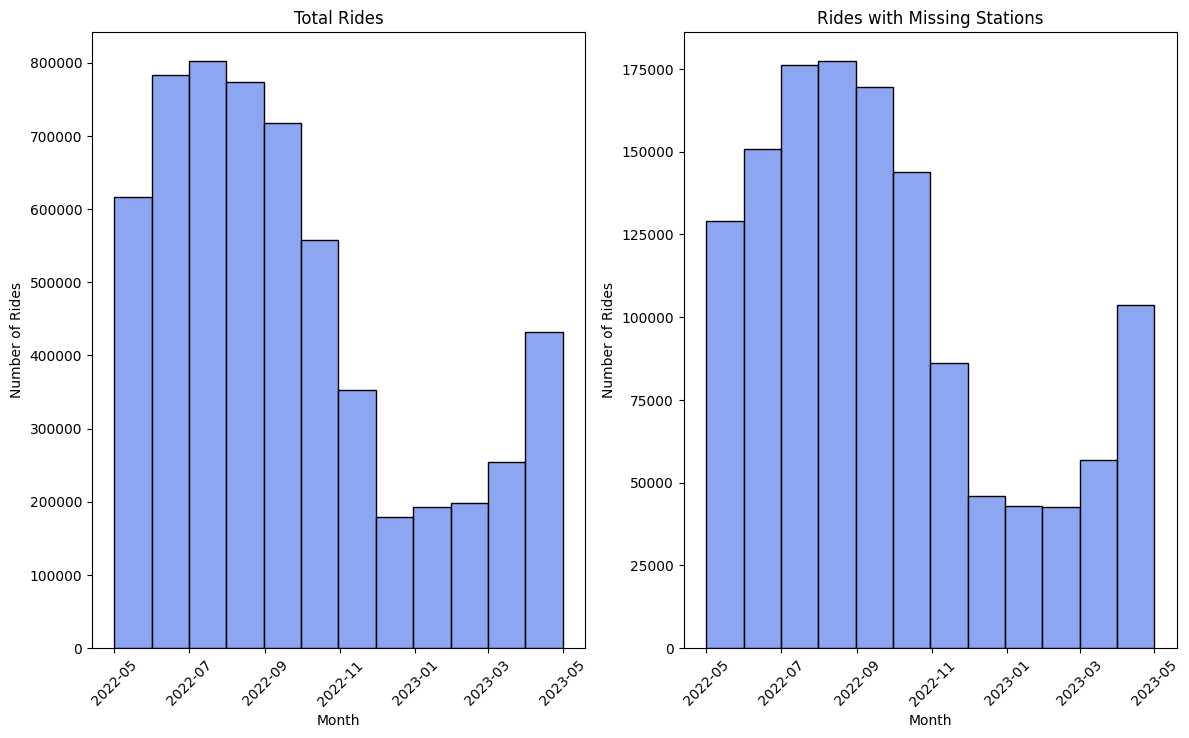

In [10]:
# Create histograms to look at distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
sns.set_palette('coolwarm')

# Histogram of all rides
sns.histplot(df['started_at'], bins=12, ax=axes[0])
axes[0].set_title('Total Rides')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Rides')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)

# Histogram of missing stations data
sns.histplot(missing_stations['started_at'], bins=12, ax=axes[1])
axes[1].set_title('Rides with Missing Stations')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Rides')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

plt.show()

In [5]:
# Drop rows with missing stations
df.dropna(subset=['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], inplace=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4533999 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             4533999 non-null  object        
 1   rideable_type       4533999 non-null  category      
 2   started_at          4533999 non-null  datetime64[ns]
 3   ended_at            4533999 non-null  datetime64[ns]
 4   start_station_name  4533999 non-null  object        
 5   start_station_id    4533999 non-null  object        
 6   end_station_name    4533999 non-null  object        
 7   end_station_id      4533999 non-null  object        
 8   start_lat           4533999 non-null  float64       
 9   start_lng           4533999 non-null  float64       
 10  end_lat             4533999 non-null  float64       
 11  end_lng             4533999 non-null  float64       
 12  member_casual       4533999 non-null  category      
 13  duration          

### Outlier Check
The data was checked for outliers. 328 rows were found with 0 or negative duration and 100 rows were found with duration greater than 24 hours (1440 minutes). There were also 8 rows with end latitude and longitude values equal to 0. The rows were removed and the resulting dataframe contained **4,533,563** rows.

In [27]:
# Statistical summary of all columns
df.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
count,4533999,4533999,4533999,4533999,4533999,4533999,4533999,4533999,4.533999e+06,4.533999e+06,4.533999e+06,4.533999e+06,4533999,4.533999e+06
unique,4533999,3,NaN,NaN,1613,1282,1651,1292,NaN,NaN,NaN,NaN,2,NaN
top,EC2DE40644C6B0F4,classic_bike,NaN,NaN,Streeter Dr & Grand Ave,13022,Streeter Dr & Grand Ave,13022,NaN,NaN,NaN,NaN,member,NaN
freq,1,2639080,NaN,NaN,70849,70849,72327,72327,NaN,NaN,NaN,NaN,2742885,NaN
mean,NaN,NaN,2022-09-18 05:55:25.043074048,2022-09-18 06:11:58.661472,NaN,NaN,NaN,NaN,4.190175e+01,-8.764498e+01,4.190202e+01,-8.764509e+01,NaN,1.656030e+01
min,NaN,NaN,2022-05-01 00:00:06,2022-05-01 00:05:17,NaN,NaN,NaN,NaN,4.164850e+01,-8.783332e+01,0.000000e+00,-8.783000e+01,NaN,-1.687000e+02
25%,NaN,NaN,2022-07-01 16:33:53,2022-07-01 16:50:27.500000,NaN,NaN,NaN,NaN,4.188103e+01,-8.765839e+01,4.188103e+01,-8.765862e+01,NaN,5.870000e+00
50%,NaN,NaN,2022-08-26 17:22:56,2022-08-26 17:40:57,NaN,NaN,NaN,NaN,4.189680e+01,-8.764189e+01,4.189745e+01,-8.764288e+01,NaN,1.030000e+01
75%,NaN,NaN,2022-11-07 07:47:27.500000,2022-11-07 07:57:32,NaN,NaN,NaN,NaN,4.192877e+01,-8.762858e+01,4.192889e+01,-8.762858e+01,NaN,1.847000e+01
max,NaN,NaN,2023-04-30 23:58:48,2023-05-01 08:06:56,NaN,NaN,NaN,NaN,4.206487e+01,-8.752531e+01,4.206485e+01,0.000000e+00,NaN,3.203545e+04


In [43]:
# Find outliers
under = df[df['duration'] <= 0].shape[0]
over = df[df['duration'] >= 1440].shape[0]
zerocoord = df[(df['end_lng'] == 0) | (df['end_lat'] == 0)].shape[0]

print(f'Number of rows with 0 or negative duration: {under}')
print(f'Number of rows with duration over 24 hours: {over}')
print(f'Number of rows with latitude or longitude equal to 0: {zerocoord}')

Number of rows with 0 or negative duration: 328
Number of rows with duration over 24 hours: 100
Number of rows with latitude or longitude equal to 0: 8


In [6]:
# Remove outliers
df = df[(df['duration'] > 0) & (df['duration'] < 1440)]
df = df[(df['end_lng'] != 0) | (df['end_lat'] != 0)]
df.shape

(4533563, 14)

In [31]:
# Export to CSV
df.to_csv('cleaned_data.csv', index=False)

In [45]:
df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,41.943670,-87.648950,member,34
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,41.886349,-87.617517,member,38
2,1542FBEC830415CF,classic_bike,2022-05-26 18:36:28,2022-05-26 18:58:18,Clinton St & Madison St,TA1305000032,Wood St & Milwaukee Ave,13221,41.882242,-87.641066,41.907655,-87.672552,member,22
3,6FF59852924528F8,classic_bike,2022-05-10 07:30:07,2022-05-10 07:38:49,Clinton St & Madison St,TA1305000032,Clark St & Randolph St,TA1305000030,41.882242,-87.641066,41.884576,-87.631890,member,9
4,483C52CAAE12E3AC,classic_bike,2022-05-10 17:31:56,2022-05-10 17:36:57,Clinton St & Madison St,TA1305000032,Morgan St & Lake St,TA1306000015,41.882242,-87.641066,41.885779,-87.651025,member,6
5,C0A3AA5A614DCE01,classic_bike,2022-05-04 14:48:55,2022-05-04 14:56:04,Carpenter St & Huron St,13196,Sangamon St & Washington Blvd,13409,41.894556,-87.653449,41.883165,-87.651100,member,8
6,F2AF43A242DF4555,classic_bike,2022-05-27 12:41:48,2022-05-27 12:50:41,Noble St & Milwaukee Ave,13290,Wood St & Augusta Blvd,657,41.900680,-87.662600,41.899181,-87.672200,member,9
7,377BE1F5F0E399CA,docked_bike,2022-05-29 19:19:24,2022-05-29 19:31:34,Halsted St & Wrightwood Ave,TA1309000061,Southport Ave & Clybourn Ave,TA1309000030,41.929143,-87.649077,41.920771,-87.663712,casual,13
8,B136E0C969773F59,classic_bike,2022-05-16 17:48:44,2022-05-16 18:05:26,Clinton St & Madison St,TA1305000032,Clybourn Ave & Division St,TA1307000115,41.882242,-87.641066,41.904613,-87.640552,member,17
9,75F6A50A05E0AA18,electric_bike,2022-05-11 07:29:29,2022-05-11 07:30:57,Southport Ave & Waveland Ave,13235,N Southport Ave & W Newport Ave,20257.0,41.948067,-87.664012,41.940000,-87.660000,member,2


### scratch work
Day Pass holders: unlimited number of 3 hour rides over a 24-hour period. If you keep a bike out for longer than 3 hours at a time, you will be charged an extra $0.17 for each additional minute.

 

Annual Members: the first 45 minutes of each ride are included in the membership price. If you keep a bike out for longer than 45 minutes at a time, you will be charged an extra $0.17 for each additional minute.

All per minute ride prices are rounded up to the nearest minute.

 

NOTE: If you do not return a bike within a 24-hour period, you may be charged a lost or stolen bike fee of $250 (plus tax).

In [23]:
df.start_station_name.value_counts().head(10)

start_station_name
Streeter Dr & Grand Ave               70837
DuSable Lake Shore Dr & Monroe St     39347
Michigan Ave & Oak St                 37817
DuSable Lake Shore Dr & North Blvd    37749
Wells St & Concord Ln                 35301
Clark St & Elm St                     33704
Millennium Park                       32824
Kingsbury St & Kinzie St              32319
Theater on the Lake                   31559
Wells St & Elm St                     29649
Name: count, dtype: int64

In [24]:
df.end_station_name.value_counts().head(10)

end_station_name
Streeter Dr & Grand Ave               72318
DuSable Lake Shore Dr & North Blvd    40788
Michigan Ave & Oak St                 38911
DuSable Lake Shore Dr & Monroe St     38236
Wells St & Concord Ln                 35634
Millennium Park                       33793
Clark St & Elm St                     33345
Theater on the Lake                   32134
Kingsbury St & Kinzie St              31174
Wells St & Elm St                     29332
Name: count, dtype: int64

In [9]:
ss = df[df['start_station_name'] == df['end_station_name']]
ss.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
count,307287,307287,307287,307287,307287,307287,307287,307287,307287.000000,307287.000000,307287.000000,307287.000000,307287,307287.000000
unique,307287,3,NaN,NaN,1283,1132,1283,1133,NaN,NaN,NaN,NaN,2,NaN
top,043D51D15887474F,classic_bike,NaN,NaN,Streeter Dr & Grand Ave,13022,Streeter Dr & Grand Ave,13022,NaN,NaN,NaN,NaN,casual,NaN
freq,1,157871,NaN,NaN,12009,12009,12009,12009,NaN,NaN,NaN,NaN,176763,NaN
mean,NaN,NaN,2022-09-10 20:05:22.080624640,2022-09-10 20:30:27.059937280,NaN,NaN,NaN,NaN,41.898112,-87.643680,41.898115,-87.643668,NaN,25.612912
min,NaN,NaN,2022-05-01 00:06:32,2022-05-01 00:13:30,NaN,NaN,NaN,NaN,41.648501,-87.830000,41.648501,-87.830000,NaN,1.000000
25%,NaN,NaN,2022-06-26 15:44:25,2022-06-26 16:09:23,NaN,NaN,NaN,NaN,41.877642,-87.658902,41.877642,-87.658865,NaN,1.000000
50%,NaN,NaN,2022-08-15 13:31:04,2022-08-15 13:56:59,NaN,NaN,NaN,NaN,41.894345,-87.638181,41.894345,-87.638181,NaN,9.000000
75%,NaN,NaN,2022-10-24 10:19:17.500000,2022-10-24 10:36:45,NaN,NaN,NaN,NaN,41.929143,-87.623777,41.929143,-87.623777,NaN,34.000000
max,NaN,NaN,2023-04-30 23:45:00,2023-05-01 07:11:32,NaN,NaN,NaN,NaN,42.064854,-87.528232,42.064854,-87.528232,NaN,1439.000000


In [13]:
grouped = df.groupby('start_station_name').agg({'duration': ['mean', 'count']})
grouped.columns = ['mean_duration', 'ride_count']
grouped.sort_values('ride_count', ascending=False, inplace=True)
grouped.head(10)


,mean_duration,ride_count
start_station_name,,
Streeter Dr & Grand Ave,32.400243,70837
DuSable Lake Shore Dr & Monroe St,32.633771,39347
Michigan Ave & Oak St,30.269958,37817
DuSable Lake Shore Dr & North Blvd,24.904739,37749
Wells St & Concord Ln,14.399082,35301
Clark St & Elm St,14.145561,33704
Millennium Park,33.587497,32824
Kingsbury St & Kinzie St,10.811504,32319
Theater on the Lake,26.076967,31559


In [12]:
ss_duration = ss.groupby(['start_station_name'])['duration'].mean().sort_values(ascending=False).head(10)
print(ss_duration)

start_station_name
Public Rack - Ellis Ave & 132nd Pl    154.000000
Hegewisch Metra Station               149.500000
Marshfield Ave & 59th St              125.571429
Altgeld Gardens                       122.066667
Ashland Ave & 63rd St                 114.050000
Michigan Ave & 114th St               111.000000
Stony Island Ave & 75th St            105.311111
Seeley Ave & Garfield Blvd            102.562500
Ashland Ave & Pershing Rd              99.347826
Halsted St & 56th St                   97.571429
Name: duration, dtype: float64


In [22]:
groupdat = pd.cut(ss.duration, 12)
groupdat.value_counts()

duration
(-1.419, 119.92]      298508
(119.92, 239.82]        7464
(239.82, 359.72]         686
(359.72, 479.62]         183
(479.62, 599.52]          87
(599.52, 719.42]          67
(839.32, 959.22]          63
(719.42, 839.32]          58
(959.22, 1079.12]         53
(1079.12, 1199.02]        43
(1199.02, 1318.92]        41
(1318.92, 1438.82]        34
Name: count, dtype: int64

In [ ]:
df['route'] = df['start_station_name'] + ' to ' + df['end_station_name']
df.head(10)

In [25]:
df.route.value_counts().head(10)

route
Streeter Dr & Grand Ave to Streeter Dr & Grand Ave                        12009
Ellis Ave & 60th St to University Ave & 57th St                            7744
DuSable Lake Shore Dr & Monroe St to DuSable Lake Shore Dr & Monroe St     7375
Ellis Ave & 60th St to Ellis Ave & 55th St                                 7331
University Ave & 57th St to Ellis Ave & 60th St                            7246
Ellis Ave & 55th St to Ellis Ave & 60th St                                 6811
Michigan Ave & Oak St to Michigan Ave & Oak St                             5675
DuSable Lake Shore Dr & Monroe St to Streeter Dr & Grand Ave               5619
Millennium Park to Millennium Park                                         4441
State St & 33rd St to Calumet Ave & 33rd St                                4205
Name: count, dtype: int64

In [ ]:
df2 = df.copy()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4533563 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  duration            int16         
dtypes: category(2), datetime64[ns](2), float64(4), int16(1), object(5)
memory usage: 432.4+ MB


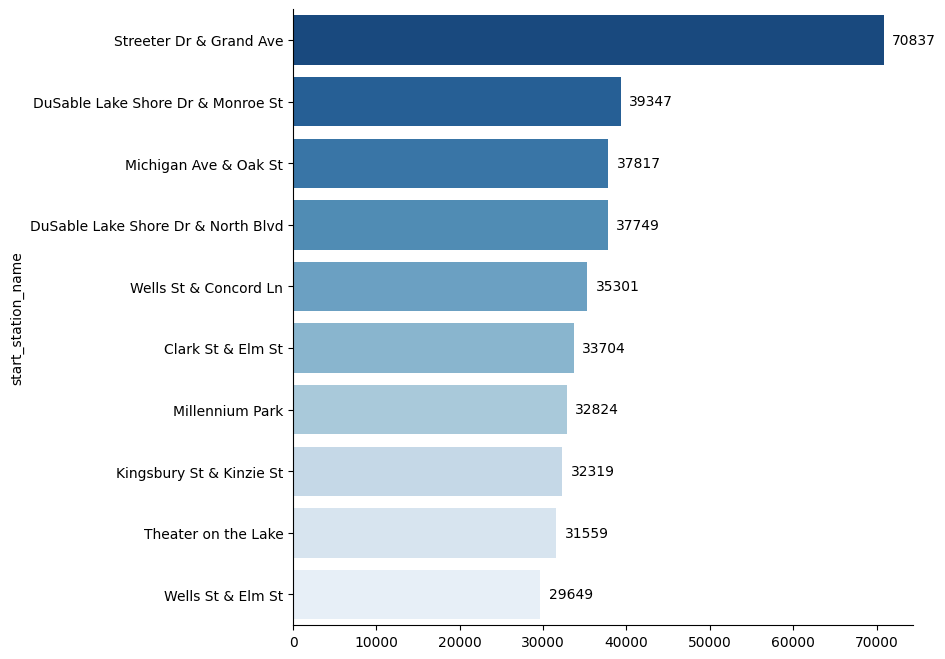

In [120]:
stations = df.start_station_name.value_counts().head(10)

plt.figure(figsize=(8, 8))
ax = sns.barplot(x=stations.values, y=stations.index, orient='h', palette='Blues_r')

for i, count in enumerate(stations.values):
    ax.text(count + 1000, i, str(count), va='center', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('')

plt.show()

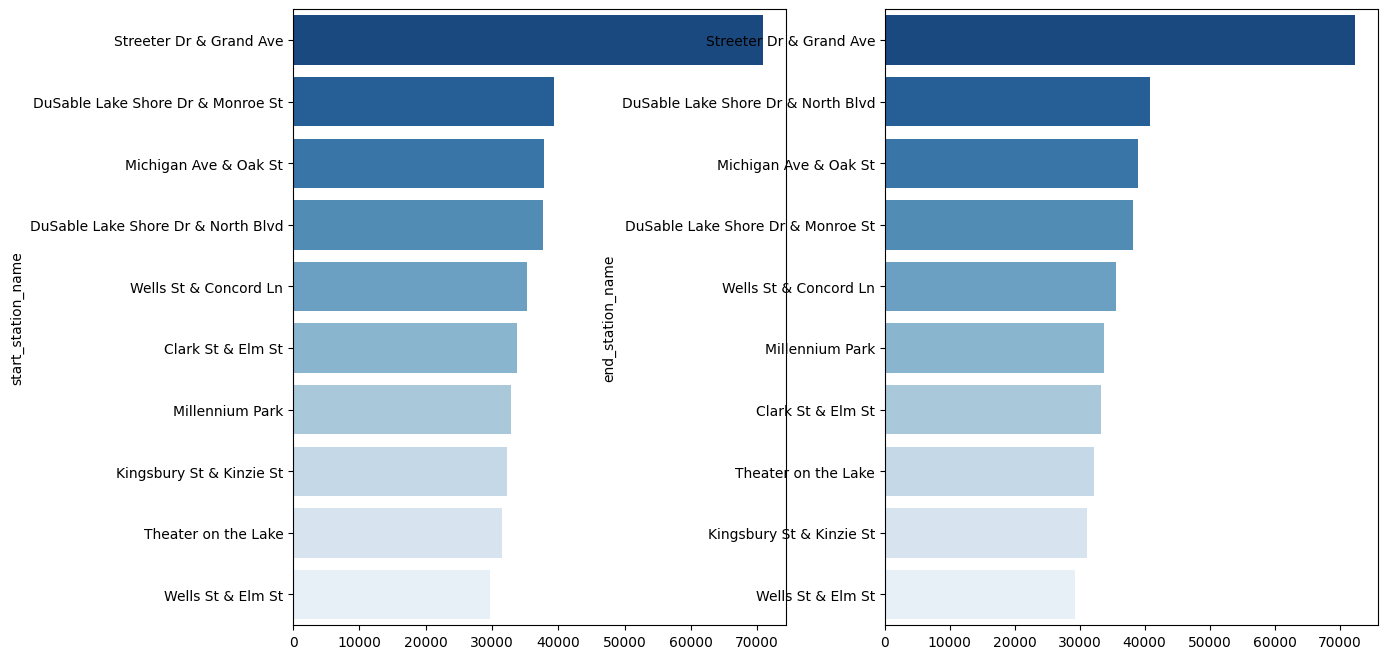

"\nfor i, count in enumerate(start_stations.values):\n    ax.text(count + 1000, i, str(count), va='center', fontsize=10)\n\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False)\n\n# Histogram of all rides\nsns.histplot(df['started_at'], bins=12, ax=axes[0])\naxes[0].set_title('Total Rides')\naxes[0].set_xlabel('Month')\naxes[0].set_ylabel('Number of Rides')\naxes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)\n\n# Histogram of missing stations data\nsns.histplot(missing_stations['started_at'], bins=12, ax=axes[1])\naxes[1].set_title('Rides with Missing Stations')\naxes[1].set_xlabel('Month')\naxes[1].set_ylabel('Number of Rides')\naxes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)\n\nplt.show()\n"

In [121]:
start_stations = df.start_station_name.value_counts().head(10)
end_stations = df.end_station_name.value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.barplot(ax=axes[0], x=start_stations.values, y=start_stations.index, orient='h', palette='Blues_r')

sns.barplot(ax=axes[1], x=end_stations.values, y=end_stations.index, orient='h', palette='Blues_r')

plt.show()


'''
for i, count in enumerate(start_stations.values):
    ax.text(count + 1000, i, str(count), va='center', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Histogram of all rides
sns.histplot(df['started_at'], bins=12, ax=axes[0])
axes[0].set_title('Total Rides')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Rides')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)

# Histogram of missing stations data
sns.histplot(missing_stations['started_at'], bins=12, ax=axes[1])
axes[1].set_title('Rides with Missing Stations')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Rides')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

plt.show()
'''

In [1]:
df.info()

NameError: name 'df' is not defined